# Budyko-Sellers Type Energy Balance Model for Earth's Temperature


Ian Fenty


This notebook benefitted from materials in Brian Rose's ATM 623: Climate Modeling course notes
Lecture 14: The one-dimensional energy balance model 

https://brian-rose.github.io/ClimateLaboratoryBook/courseware/one-dim-ebm.html

and Eli Tziperman's course notes
https://courses.seas.harvard.edu/climate/eli/Courses/EPS281r/Sources/Snowball/more/notes-energy_balance_0d.pdf

In [439]:
import numpy as np
import matplotlib.pyplot as plt

In [371]:
def spherical_band_area(lat1_deg, lat2_deg, R=6.371e6):
    """
    Compute area between two latitude bands on a sphere.

    Parameters:
        lat1_deg: lower latitude in degrees
        lat2_deg: upper latitude in degrees
        R: radius of sphere (default Earth radius in meters)

    Returns:
        area in m²
    """
    lat1 = np.radians(lat1_deg)
    lat2 = np.radians(lat2_deg)
    return 2 * np.pi * R**2 * (np.sin(lat2) - np.sin(lat1))

# Model Geometry 

In [440]:
# Number of latitude bands
N = 100                     

# Model meridional coordinate, x
# x = sin(latitude)

# Grid cell edges with coordinates
# ...each band has two edges (north and south edge)
x_edges = np.linspace(-1, 1, N+1)   # 

# Grid cell centers (midway between cell edges)
x = (x_edges[0:-1] + x_edges[1:])/2

# spacing between grid cells (uniform in x)
dx = x[1] - x[0]           


print(x_edges[:5])
print(x[:5])

# grid cell center and edge locations in radians and degrees
lat_rad = np.arcsin(x)
lat_edges_rad = np.arcsin(x_edges)

lat_deg = np.rad2deg(lat_rad)
lat_edges_deg = np.rad2deg(lat_edges_rad)

print(lat_deg[0:5])
print(lat_edges_deg[0:5])

[-1.   -0.98 -0.96 -0.94 -0.92]
[-0.99 -0.97 -0.95 -0.93 -0.91]
[-81.89038554 -75.93013225 -71.80512766 -68.43481498 -65.50535153]
[-90.         -78.52165905 -73.73979529 -70.05155641 -66.92608193]


In [441]:
# calculate area of each band (annulus) between each latitude boundary (lat_edges_deg)
area_per_band = spherical_band_area(lat_edges_deg[0], lat_edges_deg[1])

# all bands are the same area
for i in range(5):
    print('area of band ', i, spherical_band_area(lat_edges_deg[i], lat_edges_deg[i+1]), 'm2')


area of band  0 5100644719097.887 m2
area of band  1 5100644719097.887 m2
area of band  2 5100644719097.887 m2
area of band  3 5100644719097.858 m2
area of band  4 5100644719097.887 m2


# Incoming Solar Radiation

In [442]:
# Physical constants
S0 = 1366                    # Solar constant (W/m^2)
Q = S0 / 4                   # Global mean insolation

# Incoming shortwave radiation (Insolation distribution)
# modified from : S(x) = Q * (1 - 0.482 * x^2)
S_x = Q * (1 - 0.482 * x**2)*1.35-55

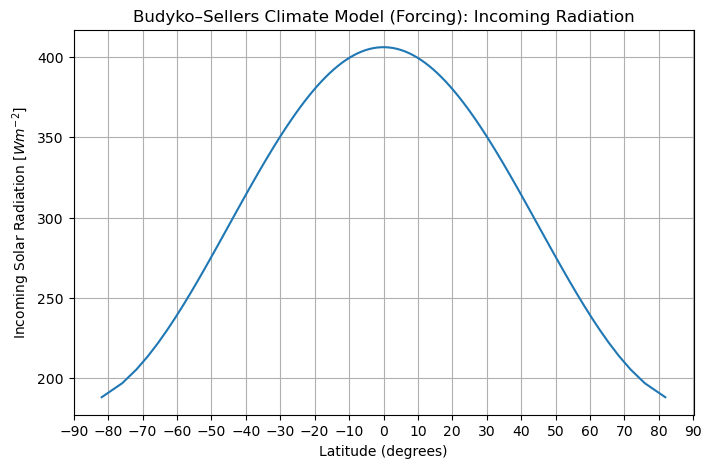

In [445]:
# plot incoming solar radiation

plt.figure(figsize=(8, 5))
plt.title('Budyko–Sellers Climate Model (Forcing): Incoming Radiation')
plt.xlabel('Latitude (degrees)')
plt.plot(lat_deg, S_x);plt.ylabel('Incoming Solar Radiation [$W m^{-2}$]');
plt.grid(True)
plt.xticks(np.linspace(-90, 90, 19));
plt.show()

# Albedo Functions

In [446]:
# simple step or more complicated linear interpolation between extremes


# simple albedo parameterization, switch between two values
def albedo_step(T):
    # define albedo to be 0.3 in open water or 0.6 where 
    # the surface temperature is below the freezing point
    return np.where(T < 273.15, 0.6, 0.3)


# more complex albedo parameterization (from Eli Tziperman course notes)
# https://courses.seas.harvard.edu/climate/eli/Courses/EPS281r/Sources/Snowball/more/notes-energy_balance_0d.pdf
def albedo_linear(T):
    T1 = 273.15 - 50
    a1 = 0.9
    
    T2 = 273.15 + 20
    a2 = 0.2
    
    DT = T2-T1
    
    albedos = np.zeros_like(T)

    for Ti, t_cur in enumerate(T):
        if t_cur <= T1:
            albedos[Ti] = a1
        elif t_cur >= T2:
            albedos[Ti] = a2
        else:
            albedos[Ti] = a1 + (a2-a1)*(t_cur - T1)/DT

    return albedos

# Meridional second derivative of surface temperature 

In [408]:

# function to calculates the second derivative (curvature) of
# the surface temperature

# note, uses the meridional coordinate 
# x = sin (phi), where phi is degrees in radians

# the second order spatial derivative has a special form
# because of the spherical geometry

# note: there is no temperature gradient to the north
# of the northermost grid cell and 
# and to the south of the southernmost grid cell

def calc_dT2dx2(T):
    
    # make empty array
    dT2dx2 = np.zeros_like(T)

    # loop through all grid cells
    N = len(T)
    for i in range(N):

        # calculate the first-order gradients
        # of T w.r.t. x
        
        # left side (gradient to the south)
        # .. if we are at the southernmost grid cell,
        if i == 0:
            # no gradient to the south because there is no more south to go
            dTdx_m = 0.0
        else:
            dTdx_m = (T[i] - T[i-1]) / dx
        
        # x-coordinate between T_i and T_{i-1}
        x_m = x_edges[i]
        
        # right side (gradient to the north)
        # ... if we are at the northernmost grid cell
        if i == N-1:
            # no gradient to the north because there is no more north to go
            dTdx_p = 0.0
        else:
            dTdx_p = (T[i+1] - T[i]) /dx 
        
        # x-coordinate between T_{i+1} and T_{i}            
        x_p = x_edges[i+1]           
        
        # dx is constant, but the "length" of the ring 
        # faces to the north and south of each band is different. 
        
        # the second derivative in this 'sphere-like' coordinate system is
        # d/dx [ (1 - x^2) dT/dx]
        
        # use standard centered differences to approximate the second
        # derivative
        dT2dx2[i]  = 1/dx * (dTdx_p * (1 - x_p**2) - dTdx_m * (1 - x_m**2))
        
    return dT2dx2
        

# Specify First-Guess Surface Temperature

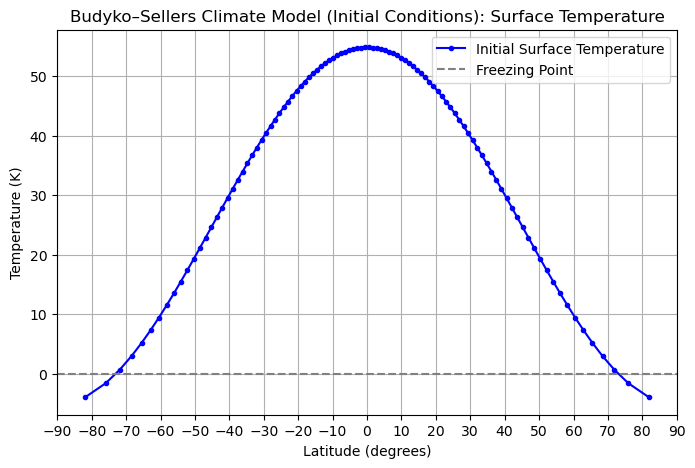

In [447]:
# Initial guess: warmer at equator

# a good first guess gets you a faster convergence
# also multiple equilibria are possible. If you pick something 
# wild then you may converge to a strange new world

T_0 = 288 + 60 * (1 - x**2)-20   

# show the first-guess temperautre
plt.figure(figsize=(8, 5))
plt.plot(lat_deg, T_0-273.15, '.b-', label='Initial Surface Temperature')
plt.axhline(0, color='gray', linestyle='--', label='Freezing Point')
plt.title('Budyko–Sellers Climate Model (Initial Conditions): Surface Temperature')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Temperature (K)')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(-90, 90, 19));
plt.show()

# Outgoing Longwave Radiation

In [448]:
# two methods for outgoing longwave radiation, a linear function of T
# or a Stefan-Boltzmann parameterization with emissivity epsilon

# outgoing solar radiation is taken to be a linear function
# of surface temperature (in degrees C)
A = 210                      # OLR intercept (W/m^2)
B = 2                        # OLR slope (W/m^2/K)


# Stefan-Boltzmann emissivity parameters
sigma = 5.67e-8 # Wm-2 K-4
epsilon = 0.63


# Meridional Heat Diffusivity

In [450]:
# effective meridional heat diffusivity coefficient
# Diffusivity (W/m^2)
D = 0.6                      

# Runtime model parameters

In [454]:
# stefan-boltzmann outgoing longwave or simple linear function
use_stefan_boltzmann = True

# allow albedo to vary with surface temperature during the solve
use_variable_albedo=True

# albedo is a linear function of surface temperature or simpler step function
use_linear_albedo = True


# Show Initial Albedo


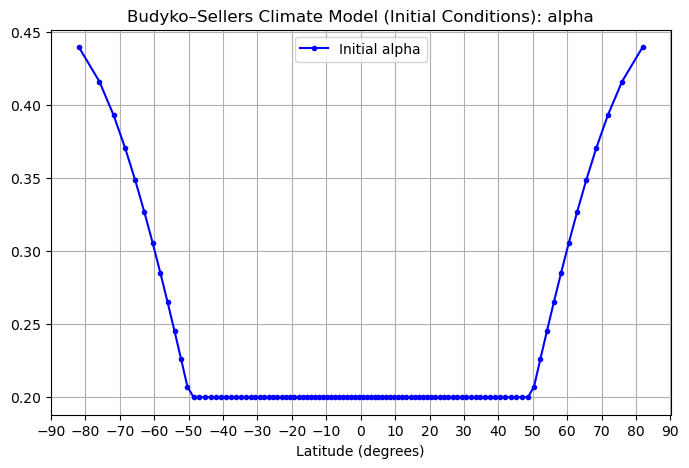

In [455]:

if use_linear_albedo:
#   linear albedo (True) or 
    alpha = albedo_linear(T_0)
else:
#   step albedo (if False)    
    alpha = albedo_step(T_0)

# plot
plt.figure(figsize=(8, 5))
plt.plot(lat_deg, alpha, '.b-', label='Initial alpha')
plt.title('Budyko–Sellers Climate Model (Initial Conditions): alpha')
plt.xlabel('Latitude (degrees)')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(-90, 90, 19));
plt.show()

# Solve for steady-state surface temperature

In [456]:

# Solver parameters: 

# ...convergence tolerance
tol = 1e-9          
# ... maximum number of iterations
max_iter = 100000
# ... model step to converge to equilibrium
dt = (dx**2) / (2 * D) * 0.5  # Add safety factor


# define some arrays to save output
F_ins = []
F_outs = []
T_s = []
F_diff_s = []
alpha_s = []

# set first-guess initial surface temperature
T= T_0 + 0 

# iterate until the solution converges or you reach max-iter
for n in range(max_iter):

    # calculate outgoing radiation
    if use_stefan_boltzmann:
        # stefan-boltzmann relation
        F_out = epsilon * sigma * T**4
    else:    
        # linear radiation relation
        F_out = A + B * (T - 273.15)
        
    # calculate incoming solar radiation
    if use_variable_albedo:
        if use_linear_albedo:
            alpha = albedo_linear(T)
        else:
            alpha = albedo_step(T)

    F_in = S_x * (1 - alpha)
    

    # Calculate meridional (diffusive) heat flux
    #  ... compute d2/dx2 T: d/dx[(1 - mu^2) dT/dx]
    dT2dx2 = calc_dT2dx2(T)
    F_diff = dT2dx2 * D
    
    # Apply update to T  (simple forward Euler)
    dTdt = F_in - F_out + F_diff
    T_increment = dt * dTdt 
    T_new = T + T_increment

    # update T variable
    T = T_new

    # save fields for analysis
    if n == 0 or n % 10000 == 0: 
        print('T convergence criteria ', np.sum(np.abs(T_increment)))
        F_diff_s.append(F_diff)
        alpha_s.append(alpha)
        F_outs.append(F_out)
        F_ins.append(F_in)
        T_s.append(T)

    # Convergence check
    if np.sum(np.abs(T_increment)) < tol:
       print(f"Converged in {n+1} iterations.")
       break
        
# save final state
F_diff_s.append(F_diff)
alpha_s.append(alpha)
F_outs.append(F_out)
F_ins.append(F_in)
T_s.append(T)

# convert lists to arrays
F_ins = np.array(F_ins).T;
F_outs = np.array(F_outs).T;
T_s = np.array(T_s).T - 273.15;
F_diff_s = np.array(F_diff_s).T;
alpha_s = np.array(alpha_s).T;

# extract final terms
# ... temperatures
T_final = T_s[:,-1]
# ... fluxes
F_out_final = F_outs[:,-1]
F_in_final = F_ins[:,-1]
F_diff_final = F_diff_s[:,-1]
# ... alpha
alpha_final = alpha_s[:,-1]

print('Energy Imbalance: ', np.sum(F_in_final - F_out_final + F_diff_final ))


T convergence criteria  1.404519483360014
T convergence criteria  0.021993690560032066
T convergence criteria  0.001968164876223822
T convergence criteria  0.00019291191340189937
T convergence criteria  1.8929162380148815e-05
T convergence criteria  1.8577581936355795e-06
T convergence criteria  1.823288442629841e-07
T convergence criteria  1.789460165801951e-08
T convergence criteria  1.756444738765243e-09
Converged in 82429 iterations.
Energy Imbalance:  -5.998815075347608e-06


# Plot results

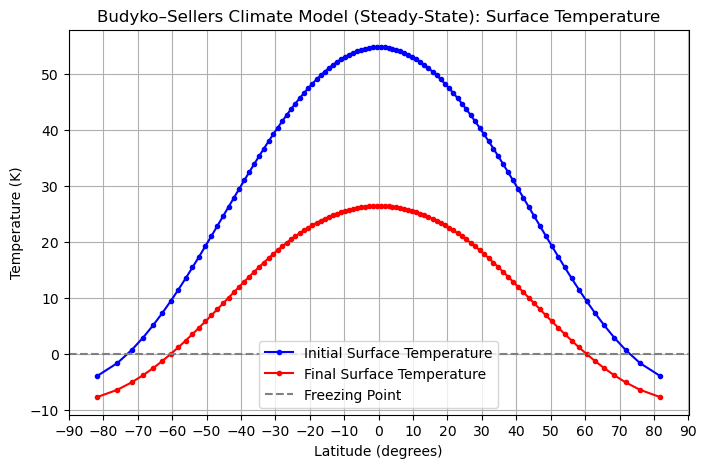

In [458]:
plt.figure(figsize=(8, 5))
plt.plot(lat_deg, T_s[:,0], '.b-', label='Initial Surface Temperature')
plt.plot(lat_deg, T_final, '.r-', label='Final Surface Temperature')
plt.axhline(0, color='gray', linestyle='--', label='Freezing Point')
plt.title('Budyko–Sellers Climate Model (Steady-State): Surface Temperature')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Temperature (K)')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(-90, 90, 19));
plt.show()

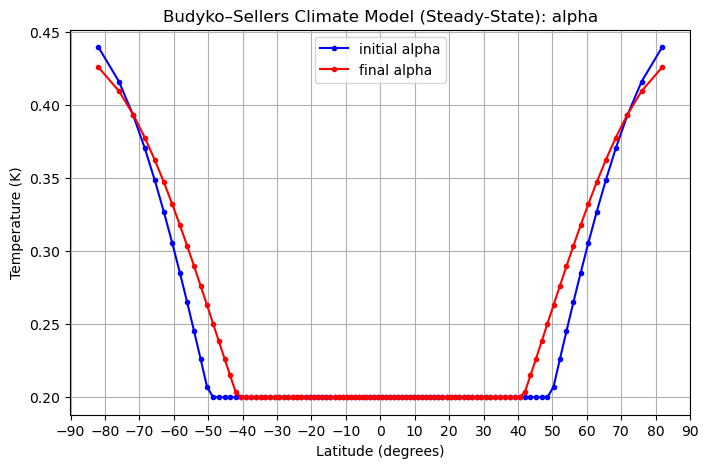

In [435]:
T_final = T_s[:,-1]
plt.figure(figsize=(8, 5))
plt.plot(lat_deg, alpha_s[:,0], '.b-', label='initial alpha')
plt.plot(lat_deg, alpha_final, '.r-', label='final alpha')
#plt.axhline(273.15, color='gray', linestyle='--', label='Freezing Point')
plt.title('Budyko–Sellers Climate Model (Steady-State): alpha')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Temperature (K)')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(-90, 90, 19));
plt.show()

In [436]:
print('f in' , F_in_final[0:5])
print('f out', -F_out_final[0:5])
print('meridional heat flux ', F_diff_final[0:5])

print('net ' , F_in[0:5] - F_out[0:5] + F_diff_final[:5])

f in [108.07976759 116.28934388 124.62246814 133.06080412 141.58583006]
f out [-204.83614678 -208.09393712 -211.30075618 -214.45355392 -217.5493177 ]
meridional heat flux  [96.7563732  91.80458733 86.67828221 81.39274405 75.96348198]
net  [-5.98397961e-06 -5.91018900e-06 -5.83168855e-06 -5.74860611e-06
 -5.66096793e-06]


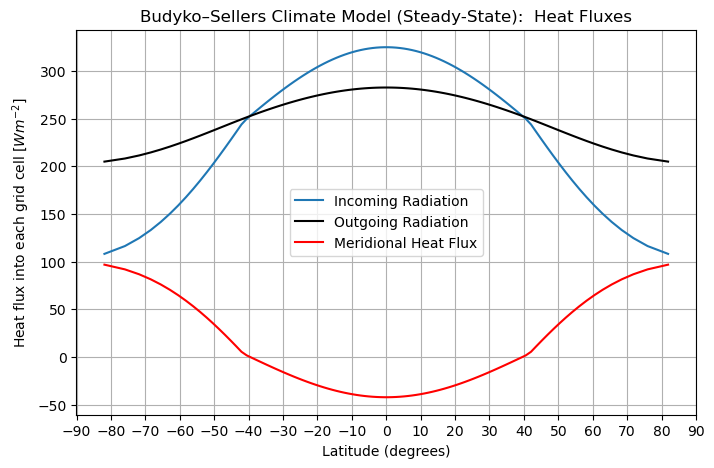

In [437]:
plt.figure(figsize=(8, 5))

plt.plot(lat_deg,F_in_final,  label='Incoming Radiation')
plt.plot(lat_deg,F_out_final,'k-',  label='Outgoing Radiation')
plt.plot(lat_deg, F_diff_final,'r-',  label='Meridional Heat Flux')

plt.title('Budyko–Sellers Climate Model (Steady-State):  Heat Fluxes')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Heat flux into each grid cell [$Wm^{-2}]$')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(-90, 90, 19));
plt.show()

/var/folders/1_/d2mlmphx1y73x199m02l7_qc0000gq/T/ipykernel_58563/274731478.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


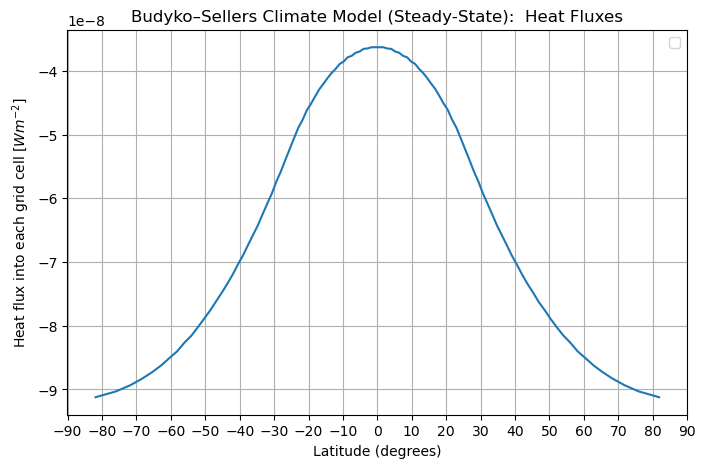

In [460]:
plt.figure(figsize=(8, 5))

plt.plot(lat_deg,F_in_final - F_out_final + F_diff_final)

plt.title('Budyko–Sellers Climate Model (Steady-State):  Heat Fluxes')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Heat flux into each grid cell [$Wm^{-2}]$')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(-90, 90, 19));
plt.show()

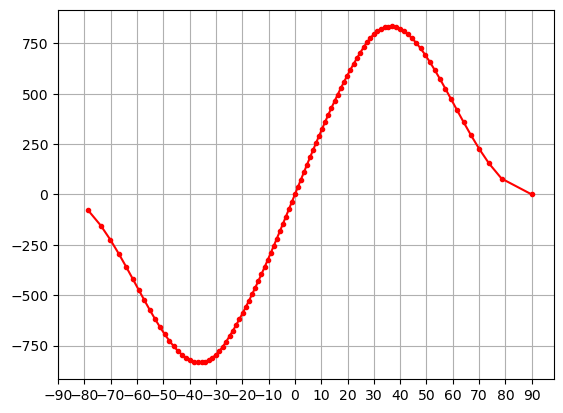

In [468]:
plt.plot(lat_edges_deg[1:],np.cumsum(F_in_final - F_out_final),'r.-')# + F_diff_final)
plt.grid()
plt.xticks(np.linspace(-90, 90, 19));


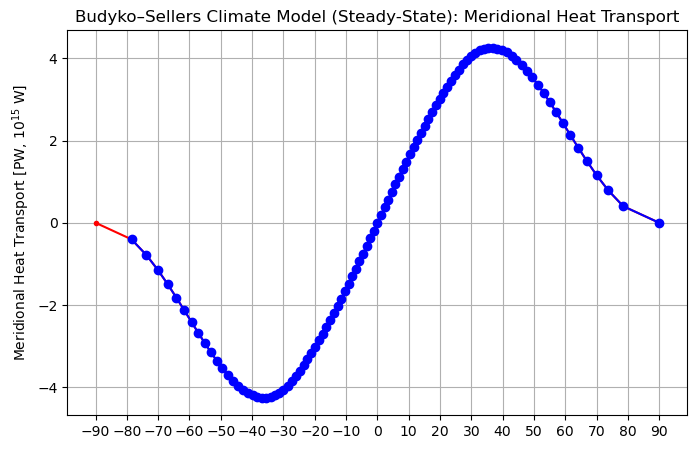

In [470]:
# calculate cumulative heat flux into each grid cell

# note, pad a zero to the left end of the array
# to account for the fact that there is no flux out of the left side
# of the last array (no lateral heat flux to the south of the south pole)

# implied heat transport into each grid cell
# balances F_in - F_out
heat_transport = dT2dx2*D

dTx = np.insert(heat_transport, 0, 0)

# convert to PW (10^15 Watts)
inferred_heat_transport = np.cumsum(-dTx) * area_per_band * 1e-15

plt.figure(figsize=(8, 5))
plt.title('Budyko–Sellers Climate Model (Steady-State): Meridional Heat Transport')
plt.plot(lat_edges_deg, inferred_heat_transport, 'r.-');plt.grid()
plt.plot(lat_edges_deg[1:],area_per_band * 1e-15*np.cumsum(F_in_final - F_out_final),'bo-')# + F_diff_final)

plt.xticks(np.linspace(-90, 90, 19));
plt.ylabel('Meridional Heat Transport [PW, $10^{15}$ W]')
plt.show()